In [92]:
import pandas as pd
import numpy as np
import yaml
import pickle
from sklearn import tree
import shap
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
shap.initjs()
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
#import catboost
#from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math
import warnings
warnings.filterwarnings('ignore')

In [93]:
comb_raw_shap = pd.read_excel('comb.xlsx', index_col=0)
comb_raw_shap.head()

INVOICE_NB INVOICE_DATE  MOIS  ANNEE  COUNTRY      CHANNEL  \
0   720222171   2015-01-06     1   2015   France  AFTERMARKET   
1   720222171   2015-01-06     1   2015   France  AFTERMARKET   
2   720222826   2015-01-14     1   2015  Finland  AFTERMARKET   
3   720222826   2015-01-14     1   2015  Finland  AFTERMARKET   
4   720222828   2015-01-14     1   2015   Poland  AFTERMARKET   

                          SEGMENT  CUSTOMER_NUMBER                    CLIENT  \
0  DS-Non Specialized Contractors            14302              COFRISET SAS   
1  DS-Non Specialized Contractors            14302              COFRISET SAS   
2  DS-Non Specialized Contractors            14373                AHLSELL OY   
3  DS-Non Specialized Contractors            14373                AHLSELL OY   
4  DS-Non Specialized Contractors            14414  BEIJER REF POLSKA SP ZOO   

  NATURE  ... REFRIGERANT_TYPE_R404A_SHAP REFRIGERANT_TYPE_R407C_SHAP  \
0    CPR  ...                   -0.023527                    0.000405   
1    NaN  ...                   -0.019451                    0.000334   
2    CPR  ...                   -0.003661                    0.000339   
3    CPR  ...                   -0.006641                    0.000443   
4    CPR  ...                    0.001137                    0.003185   

  LEGACY_REFRIGERANT_No_SHAP LEGACY_REFRIGERANT_Yes (A2L & A3)_SHAP  \
0                  -0.093724                              -0.001802   
1                   0.035300                              -0.001598   
2                  -0.005281                              -0.001960   
3                  -0.004292                               0.004061   
4                  -0.001534                              -0.000771   

  LEGACY_REFRIGERANT_Yes (A2L)_SHAP LEGACY_REFRIGERANT_Yes (A3)_SHAP  \
0                          0.002959                         0.003621   
1                         -0.001788                         0.003691   
2                          0.006880                         0.005337   
3                         -0.004565                         0.005355   
4                          0.011417                         0.002154   

   LEGACY_REFRIGERANT_yes (A2L)_SHAP TEMPERATURE_High Temperature_SHAP  \
0                           0.009175                          0.005374   
1                           0.005708                          0.004154   
2                           0.004730                          0.008127   
3                           0.006982                          0.008168   
4                           0.003098                          0.005529   

   EXCLUSIVE_TECH_no_SHAP  EASY_INSTALL_1 (T-Connect)_SHAP  
0               -0.001972                         0.011821  
1               -0.001750                         0.034551  
2               -0.002047                        -0.034252  
3               -0.002033                         0.093246  
4               -0.003263                         0.422525  

[5 rows x 194 columns]

In [94]:
## Automated scripts for plotting Violin Plots for top 30 Products except Country for the given Feature ##
feat = 'ROBUSTNESS'
feat_shap = [c for c in comb_raw_shap.columns if c == feat + "_SHAP"][0]
binned1 = pd.cut(comb_raw_shap[feat], bins=5)  # need to make a bin because the feature is continuous
data = None
for b in binned1.unique():
    mask = (comb_raw_shap[feat] <= b.right) & (comb_raw_shap[feat] > b.left)
    x = comb_raw_shap[mask][feat_shap].rename(feat_shap)
    y = binned1[mask].rename(feat)
    if data is None:
        data = pd.concat((x, y), axis=1)
    else:
        data = pd.concat((data, pd.concat((x, y), axis=1)), axis=0, ignore_index=True)

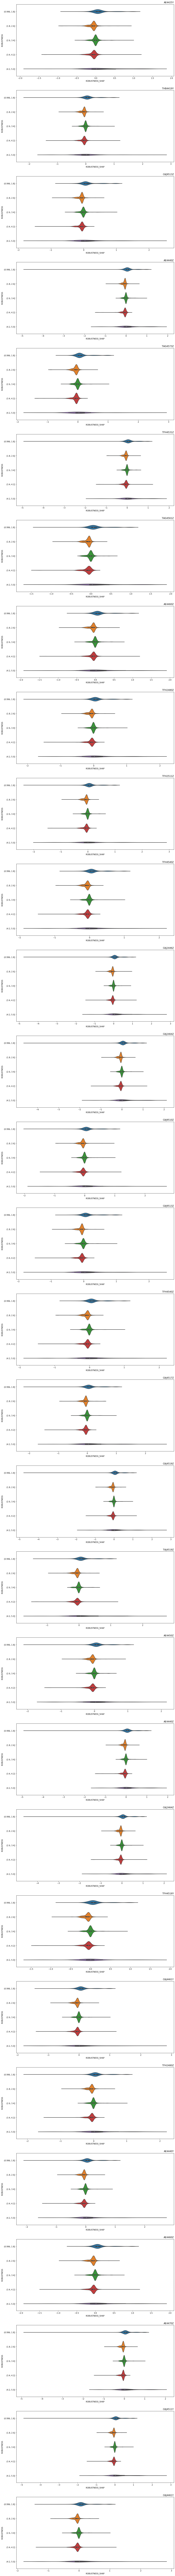

In [103]:
count = 0
plt.figure(figsize=(15,250))
for product in enumerate(comb_raw_shap["COMMERCIAL_NAME"][:30]):
    count = count + 1
    mask_product = comb_raw_shap['COMMERCIAL_NAME'] == product[1]
    plt.subplot(30, 1,product[0]+1)
    plt.title(str(product[1]), loc="right")
    sns.violinplot(y=data[feat][mask_product], x=data[feat_shap][mask_product], orient='h')

In [ ]:
# Automated scripts for plotting Violin Plots for top 30 Products For Country for the given Feature#

In [143]:
T1 = comb_raw_shap[comb_raw_shap.columns[(pd.Series(comb_raw_shap.columns).str.contains("COUNTRY_"))]]
T2 = comb_raw_shap[comb_raw_shap.columns[(pd.Series(comb_raw_shap.columns).str.contains("COUNTRY"))]]

In [148]:
m1_exc_C = pd.DataFrame(T1)
m2_with_C = pd.DataFrame(T2)

In [152]:
m1_exc_C.head()

COUNTRY_Albania_SHAP  COUNTRY_Algeria_SHAP  COUNTRY_Argentina_SHAP  \
0                     0              0.014260                       0   
1                     0              0.014260                       0   
2                     0              0.014122                       0   
3                     0              0.014122                       0   
4                     0              0.014122                       0   

   COUNTRY_Armenia_SHAP  COUNTRY_Austria_SHAP  COUNTRY_Azerbaijan_SHAP  \
0              0.000160             -0.016817                        0   
1              0.000160             -0.016833                        0   
2              0.000385             -0.038953                        0   
3              0.000432             -0.042183                        0   
4              0.000206             -0.382115                        0   

   COUNTRY_Bahrain_SHAP  COUNTRY_Barbados_SHAP  COUNTRY_Belarus_SHAP  \
0                     0                      0              0.003386   
1                     0                      0              0.003302   
2                     0                      0              0.005137   
3                     0                      0              0.005510   
4                     0                      0              0.018068   

   COUNTRY_Belgium_SHAP  ...  COUNTRY_Switzerland_SHAP  COUNTRY_Taiwan_SHAP  \
0              0.012776  ...                 -0.007334                    0   
1              0.019333  ...                 -0.007339                    0   
2              0.062438  ...                 -0.017152                    0   
3              0.012538  ...                 -0.016248                    0   
4             -0.271538  ...                 -0.202013                    0   

   COUNTRY_Tunisia_SHAP  COUNTRY_Turkey_SHAP  COUNTRY_Ukraine_SHAP  \
0             -0.000705             0.872298              0.075854   
1             -0.000594             0.600867              0.077136   
2             -0.001225             0.030107              0.210039   
3             -0.001156             0.064958              0.217660   
4             -0.004417             0.078497              0.162907   

   COUNTRY_United Arab Emirates_SHAP  COUNTRY_United Kingdom_SHAP  \
0                           0.001163                    -0.276638   
1                           0.001163                    -0.275687   
2                           0.000337                    -0.119262   
3                           0.000337                    -0.115740   
4                           0.000617                    -0.126611   

   COUNTRY_United States_SHAP  COUNTRY_Uzbekistan_SHAP  COUNTRY_Venezuela_SHAP  
0                           0                        0                       0  
1                           0                        0                       0  
2                           0                        0                       0  
3                           0                        0                       0  
4                           0                        0                       0  

[5 rows x 86 columns]

In [157]:
m2_with_C.drop(['SALES_PER_COUNTRY_PREV_YEAR',
       'SALES_PER_COUNTRY_PREV_YEAR_SHAP', 'COUNTRY_Albania_SHAP',
       'COUNTRY_Algeria_SHAP', 'COUNTRY_Argentina_SHAP',
       'COUNTRY_Armenia_SHAP', 'COUNTRY_Austria_SHAP',
       'COUNTRY_Azerbaijan_SHAP', 'COUNTRY_Bahrain_SHAP',
       'COUNTRY_Barbados_SHAP', 'COUNTRY_Belarus_SHAP', 'COUNTRY_Belgium_SHAP',
       'COUNTRY_Brazil_SHAP', 'COUNTRY_Bulgaria_SHAP', 'COUNTRY_Cameroon_SHAP',
       'COUNTRY_Canada_SHAP', 'COUNTRY_China_SHAP', 'COUNTRY_Colombia_SHAP',
       'COUNTRY_Costa Rica_SHAP', 'COUNTRY_Croatia_SHAP',
       'COUNTRY_Cyprus_SHAP', 'COUNTRY_Czech Republic_SHAP',
       'COUNTRY_Denmark_SHAP', 'COUNTRY_Dominican Republic_SHAP',
       'COUNTRY_Ecuador_SHAP', 'COUNTRY_Egypt_SHAP', 'COUNTRY_Estonia_SHAP',
       'COUNTRY_Finland_SHAP', 'COUNTRY_France_SHAP', 'COUNTRY_Gabon_SHAP',
       'COUNTRY_Germany_SHAP', 'COUNTRY_Ghana_SHAP', 'COUNTRY_Greece_SHAP',
       'COUNTRY_Guatemala_SHAP', 'COUNTRY_Hong Kong_SHAP',
       'COUNTRY_Hungary_SHAP', 'COUNTRY_India_SHAP', 'COUNTRY_Indonesia_SHAP',
       'COUNTRY_Iran, Islamic Republic of_SHAP', 'COUNTRY_Ireland_SHAP',
       'COUNTRY_Israel_SHAP', 'COUNTRY_Italy_SHAP', 'COUNTRY_Jordan_SHAP',
       'COUNTRY_Kazakhstan_SHAP', 'COUNTRY_Korea, Republic of_SHAP',
       'COUNTRY_Kuwait_SHAP', 'COUNTRY_Latvia_SHAP', 'COUNTRY_Lebanon_SHAP',
       'COUNTRY_Libya_SHAP', 'COUNTRY_Lithuania_SHAP',
       'COUNTRY_Mauritius_SHAP', 'COUNTRY_Moldova, Republic of_SHAP',
       'COUNTRY_Morocco_SHAP', 'COUNTRY_Netherlands_SHAP',
       'COUNTRY_New Caledonia_SHAP', 'COUNTRY_Nicaragua_SHAP',
       'COUNTRY_Nigeria_SHAP', 'COUNTRY_Norway_SHAP', 'COUNTRY_Oman_SHAP',
       'COUNTRY_Pakistan_SHAP', 'COUNTRY_Palestinian Territory,Occupied_SHAP',
       'COUNTRY_Panama_SHAP', 'COUNTRY_Paraguay_SHAP', 'COUNTRY_Peru_SHAP',
       'COUNTRY_Poland_SHAP', 'COUNTRY_Portugal_SHAP', 'COUNTRY_Qatar_SHAP',
       'COUNTRY_Romania_SHAP', 'COUNTRY_Russian Federation_SHAP',
       'COUNTRY_Saudi Arabia_SHAP', 'COUNTRY_Senegal_SHAP',
       'COUNTRY_Serbia_SHAP', 'COUNTRY_Singapore_SHAP',
       'COUNTRY_Slovakia_SHAP', 'COUNTRY_Slovenia_SHAP',
       'COUNTRY_South Africa_SHAP', 'COUNTRY_Spain_SHAP',
       'COUNTRY_Sweden_SHAP', 'COUNTRY_Switzerland_SHAP',
       'COUNTRY_Taiwan_SHAP', 'COUNTRY_Tunisia_SHAP', 'COUNTRY_Turkey_SHAP',
       'COUNTRY_Ukraine_SHAP', 'COUNTRY_United Arab Emirates_SHAP',
       'COUNTRY_United Kingdom_SHAP', 'COUNTRY_United States_SHAP',
       'COUNTRY_Uzbekistan_SHAP', 'COUNTRY_Venezuela_SHAP'], axis=1, inplace=True)

In [158]:
m2_with_C

COUNTRY
0        France
1        France
2       Finland
3       Finland
4        Poland
...         ...
187331   Turkey
187332  Germany
187333    Italy
187334   Serbia
187335   Israel

[187336 rows x 1 columns]

In [160]:
data2 = pd.concat([m1_exc_C,m2_with_C ], axis=1)

In [161]:
data2

COUNTRY_Albania_SHAP  COUNTRY_Algeria_SHAP  COUNTRY_Argentina_SHAP  \
0                          0              0.014260                       0   
1                          0              0.014260                       0   
2                          0              0.014122                       0   
3                          0              0.014122                       0   
4                          0              0.014122                       0   
...                      ...                   ...                     ...   
187331                     0              0.012363                       0   
187332                     0              0.007435                       0   
187333                     0              0.004568                       0   
187334                     0              0.120445                       0   
187335                     0              0.030321                       0   

        COUNTRY_Armenia_SHAP  COUNTRY_Austria_SHAP  COUNTRY_Azerbaijan_SHAP  \
0                   0.000160             -0.016817                        0   
1                   0.000160             -0.016833                        0   
2                   0.000385             -0.038953                        0   
3                   0.000432             -0.042183                        0   
4                   0.000206             -0.382115                        0   
...                      ...                   ...                      ...   
187331              0.000134             -0.046422                        0   
187332              0.000233             -0.019418                        0   
187333              0.000099             -0.012105                        0   
187334              0.000201             -0.033661                        0   
187335              0.000123             -0.019540                        0   

        COUNTRY_Bahrain_SHAP  COUNTRY_Barbados_SHAP  COUNTRY_Belarus_SHAP  \
0                          0                      0              0.003386   
1                          0                      0              0.003302   
2                          0                      0              0.005137   
3                          0                      0              0.005510   
4                          0                      0              0.018068   
...                      ...                    ...                   ...   
187331                     0                      0              0.007104   
187332                     0                      0              0.003733   
187333                     0                      0              0.004139   
187334                     0                      0              0.003649   
187335                     0                      0              0.003345   

        COUNTRY_Belgium_SHAP  ...  COUNTRY_Taiwan_SHAP  COUNTRY_Tunisia_SHAP  \
0                   0.012776  ...                    0             -0.000705   
1                   0.019333  ...                    0             -0.000594   
2                   0.062438  ...                    0             -0.001225   
3                   0.012538  ...                    0             -0.001156   
4                  -0.271538  ...                    0             -0.004417   
...                      ...  ...                  ...                   ...   
187331              0.003283  ...                    0             -0.000996   
187332              0.060501  ...                    0             -0.000581   
187333              0.043272  ...                    0             -0.003737   
187334             -0.046552  ...                    0             -0.001208   
187335             -0.009672  ...                    0             -0.001149   

        COUNTRY_Turkey_SHAP  COUNTRY_Ukraine_SHAP  \
0                  0.872298              0.075854   
1                  0.600867              0.077136   
2                  0.030107              0.210039   
3                  0.064

In [163]:
feat_1 = 'COUNTRY'

In [178]:
feat_shap_1 = [c for c in data2.columns if c.startswith('COUNTRY_') & c.endswith('_SHAP')][0:86]

In [ ]:
#feat_1 = 'COUNTRY'
#feat_shap_5 = [c for c in data2.columns if c.startswith('COUNTRY_') & c.endswith('_SHAP')][0]
#binned2 = pd.cut(comb_raw_shap[feat_1], bins=5)  # need to make a bin because the feature is continuous
#data = None
#for b in binned2.unique():
    #mask = (comb_raw_shap[feat] <= b.right) & (comb_raw_shap[feat] > b.left)
    #x = comb_raw_shap[mask][feat_shap].rename(feat_shap)
    #y = binned1[mask].rename(feat)
    #if data is None:
        #data = pd.concat((x, y), axis=1)
    #else:
        #data = pd.concat((data, pd.concat((x, y), axis=1)), axis=0, ignore_index=True)

In [354]:
feat_1 = 'COUNTRY'
count = 0
plt.figure(figsize=(15,900))
for product1 in enumerate(comb_raw_shap["COMMERCIAL_NAME"][:30]):
    count = count + 1
    mask_product2 = comb_raw_shap['COMMERCIAL_NAME'] == product1[1]
    plt.subplot(30,1,product1[0]+1)
    plt.title(str(product1[1]), loc="right")
    sns.violinplot(y=data2[feat_1][mask_product2], x=data2['COUNTRY_France_SHAP'][mask_product2], orient='h', scale="width",palette="Set3")

In [307]:
feat_shap_1

['COUNTRY_Albania_SHAP',
 'COUNTRY_Algeria_SHAP',
 'COUNTRY_Argentina_SHAP',
 'COUNTRY_Armenia_SHAP',
 'COUNTRY_Austria_SHAP',
 'COUNTRY_Azerbaijan_SHAP',
 'COUNTRY_Bahrain_SHAP',
 'COUNTRY_Barbados_SHAP',
 'COUNTRY_Belarus_SHAP',
 'COUNTRY_Belgium_SHAP',
 'COUNTRY_Brazil_SHAP',
 'COUNTRY_Bulgaria_SHAP',
 'COUNTRY_Cameroon_SHAP',
 'COUNTRY_Canada_SHAP',
 'COUNTRY_China_SHAP',
 'COUNTRY_Colombia_SHAP',
 'COUNTRY_Costa Rica_SHAP',
 'COUNTRY_Croatia_SHAP',
 'COUNTRY_Cyprus_SHAP',
 'COUNTRY_Czech Republic_SHAP',
 'COUNTRY_Denmark_SHAP',
 'COUNTRY_Dominican Republic_SHAP',
 'COUNTRY_Ecuador_SHAP',
 'COUNTRY_Egypt_SHAP',
 'COUNTRY_Estonia_SHAP',
 'COUNTRY_Finland_SHAP',
 'COUNTRY_France_SHAP',
 'COUNTRY_Gabon_SHAP',
 'COUNTRY_Germany_SHAP',
 'COUNTRY_Ghana_SHAP',
 'COUNTRY_Greece_SHAP',
 'COUNTRY_Guatemala_SHAP',
 'COUNTRY_Hong Kong_SHAP',
 'COUNTRY_Hungary_SHAP',
 'COUNTRY_India_SHAP',
 'COUNTRY_Indonesia_SHAP',
 'COUNTRY_Iran, Islamic Republic of_SHAP',
 'COUNTRY_Ireland_SHAP',
 'COUNTRY_I